<a href="https://colab.research.google.com/github/deding2000/COMP5329_Ass2/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount to google drive folder to get python files
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount('/content/gdrive')
data_path = '/content/gdrive/My Drive/COMP5329_Assignments/Assignment1-Dataset/'

Mounted at /content/drive


Get python files and augmented data

In [ ]:
from google.colab import files
uploaded = files.upload() # select all python files from the github page and kaggle.json

Saving best_samples_weight_full.pt to best_samples_weight_full.pt
Saving best_samples_weight_subset.pt to best_samples_weight_subset.pt
Saving compute_mean_std.py to compute_mean_std.py
Saving Dataload.py to Dataload.py
Saving F1_test.py to F1_test.py
Saving image_sizes.py to image_sizes.py
Saving kaggle.json to kaggle.json
Saving main.py to main.py
Saving main_notebook.ipynb to main_notebook.ipynb
Saving main_notebook_rosa.ipynb to main_notebook_rosa.ipynb
Saving metrics.py to metrics.py
Saving metrics_each_class.py to metrics_each_class.py
Saving models.py to models.py
Saving NEW_weighted_sampler.py to NEW_weighted_sampler.py
Saving norm_samples_weight_full.pt to norm_samples_weight_full.pt
Saving norm_samples_weight_subset.pt to norm_samples_weight_subset.pt
Saving README.md to README.md
Saving requirements.txt to requirements.txt
Saving rnn_test.ipynb to rnn_test.ipynb
Saving samples_weight.pt to samples_weight.pt
Saving samples_weight_subset.pt to samples_weight_subset.pt
Saving s

Get data from kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'multi-label-classification-competition-2025'
! mkdir Dataset
! unzip multi-label-classification-competition-2025.zip -d Dataset &> /dev/null

 99% 396M/399M [00:00<00:00, 1.38GB/s]
100% 399M/399M [00:00<00:00, 1.38GB/s]


Defining model arcitechture - A CNN similar to AlexNet

In [ ]:
# Model arcitechture
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define convolutional kernels and number of kernels in each layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=8, stride=4, padding=0)
        self.conv2 = nn.Conv2d(64,128, 5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128,192, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(192,192,3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(192,128,3, stride=1,padding=1)
        # Defining overlapping maxpools
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.pool3 = nn.MaxPool2d(3,stride=2)
        # Adding batch norm
        self.bn1 = nn.BatchNorm2d(16*2*2)
        self.bn2 = nn.BatchNorm2d(32*2*2)
        self.bn3 = nn.BatchNorm2d(192)
        self.bn4 = nn.BatchNorm2d(192)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm1d(150)
        self.bn7 = nn.BatchNorm1d(64)
        # Adding dropout for some layers
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.5)
        # Defining fully connected hidden layers and output layer
        self.fc1 = nn.Linear(4608,150)
        self.fc2 = nn.Linear(150,64)
        self.fc3 = nn.Linear(64,18)

    def forward(self, x):
        # Define forward operation in network
        # Convolutional layers
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        #x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        #x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        # Fully connected layers
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout3(x)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn7(self.fc2(x)))
        # Output layer
        logits = self.fc3(x)
        return logits

Setup dataloaders and initialize model

In [51]:
# Loading relevant packages
import re
import pandas as pd
from io import StringIO
import os
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split, WeightedRandomSampler
import numpy as np
from tqdm import tqdm
import shutil
import zipfile
# Custom made modules
from Dataload import pil_process_image_color, encode, Dataset, CustomImageDataset
from utils import train_network, pos_weight, test
from metrics import compute_metrics

################ Hyperparameters ###############################
batch_size = 64
lr = 0.003
weight_decay = 0
INPUT_HEIGHT = 256
INPUT_WIDTH = 256

################ Techniques for class imbalance ###############################
Normalize_weights = True # To use normalized class weights or not
use_weighted_sampler = False # To use weighted sampling or not
use_weighted_loss = False # To use weighed loss function or not
aug_all = False #augment all or add more augmentation to non-class 1 datapoints

################ Set device ###############################
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

################ Loading data and labels ###############################
DATASET_PATH = "/content/Dataset/COMP5329S1A2Dataset/"
FILENAME_TRAIN = 'train.csv'
FILENAME_TEST = 'test.csv'
FILENAME_TRAIN_AUG = 'train_aug.csv' # augmented data for training

my_dir = r"/content/Dataset/COMP5329S1A2Dataset/data/"
my_zip = r"/content/Dataset/COMP5329S1A2Dataset/FULL_augmented_images.zip"

# Copying augmented data to datapath without creating new folder
with zipfile.ZipFile(my_zip) as zip_file:
    for member in zip_file.namelist():
        filename = os.path.basename(member)
        # skip directories
        if not filename:
            continue

        # copy file (taken from zipfile's extract)
        source = zip_file.open(member)
        target = open(os.path.join(my_dir, filename), "wb")
        with source, target:
            shutil.copyfileobj(source, target)

# Load csv files containing labels
with open(DATASET_PATH + FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(DATASET_PATH + FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df_train.to_csv("train_labels_captions.csv")
df_test.to_csv("test_labels_captions.csv")
df_train_bigger = pd.read_csv("/content/Dataset/COMP5329S1A2Dataset/train_aug.csv")

################ Defining transforms ######################
resize = transforms.Resize(size=(INPUT_HEIGHT,
        INPUT_WIDTH)) # For resizing images to square

# Data augmentation
trainTransforms_augment = transforms.Compose(
    [resize,transforms.RandomHorizontalFlip(),transforms.RandomAffine(degrees=30),
     transforms.ColorJitter(),transforms.RandomCrop(size=256,pad_if_needed=True),
     transforms.RandomApply([transforms.GaussianBlur(3)], p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])

if aug_all: # If we use all augmentation on all images
    trainTransforms_basic = trainTransforms_augment
else: # We use the following augmentation on the most common class
  trainTransforms_basic = transforms.Compose(
      [resize,transforms.ColorJitter(),transforms.RandomCrop(size=256,pad_if_needed=True),
     transforms.ToTensor()
      ,transforms.Normalize(mean=[0.3598, 0.3480, 0.3270], std=[0.1929, 0.1884, 0.1901])])

# Transform for test images
testTransforms = transforms.Compose([resize,transforms.ToTensor(),
    transforms.Normalize(mean=[0.4652, 0.4492, 0.4214], std=[0.2317, 0.2265, 0.2303])])

################ Sampling method and Dataloaders ###############################
if Normalize_weights:
  # Calculate weights for loss function
  c_weights = pos_weight(df_train,barplot=False,normalize=True)
  samples_weight = torch.load("/content/norm_samples_weight_full.pt") # Sample common class less (normalized weights)
else:
  c_weights = pos_weight(df_train,barplot=False,normalize=False)
  samples_weight = torch.load("/content/unnorm_samples_weight_full.pt") # Sample common class less (unormalized weights)

weighted_sampler_full = WeightedRandomSampler(samples_weight, len(samples_weight))

# Create dataloaders
training_data = CustomImageDataset(df_train_bigger,DATASET_PATH+"data/",transform=trainTransforms_basic,transform_aug=trainTransforms_augment,target_transform=encode)
test_data = CustomImageDataset(df_test,DATASET_PATH+"data/",transform=testTransforms,target_transform=None,targets_available=False)
if use_weighted_sampler:
  train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=weighted_sampler_full)
else: # If not using weighted sampling just use shuffle
  train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data,shuffle=False)

################ Setup Model ###############################
model = CNN().to(device)

# Use BCE loss
if use_weighted_loss:
  loss = torch.nn.BCEWithLogitsLoss(c_weights.to(device))
else:
  loss = torch.nn.BCEWithLogitsLoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print('Model initialized.')

We are using GPU.
Class counts: tensor([22794.,  1162.,  4364.,  1272.,  1130.,  1394.,  1221.,  2210.,  1042.,
         1471.,   604.,   605.,   251.,  1934.,  1099.,  1430.,  1525.,  1020.],
       dtype=torch.float64)
Class weights: tensor([0.0110, 0.2160, 0.0575, 0.1973, 0.2221, 0.1801, 0.2056, 0.1136, 0.2409,
        0.1706, 0.4156, 0.4149, 1.0000, 0.1298, 0.2284, 0.1755, 0.1646, 0.2461],
       dtype=torch.float64)
Model initialized.


Training on subset (80\%) of all data and compute metrics for validation set (20\%)

In [49]:
# Loading indices for 80/20 split of training data
train_idx = np.load("/content/subset_train_indices.npy")
validation_idx = np.load("/content/validation_indices.npy")

# Loading sample weights to sample some classes more than others
if Normalize_weights:
  samples_weight_subset = torch.load("/content/norm_samples_weight_subset.pt")
else:
  samples_weight_subset = torch.load("/content/unnorm_samples_weight_subset.pt") # Sample common class less
weigthed_sampler_subset = WeightedRandomSampler(samples_weight_subset,len(samples_weight_subset))

# Subset dataset for train and val
subset_train_dataset = Subset(training_data, train_idx)
validation_dataset = Subset(training_data, validation_idx)
if use_weighted_sampler:
  subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,sampler=weigthed_sampler_subset)
else:
  subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size,shuffle=True)

validation_loader = DataLoader(validation_dataset, shuffle=False)

# Training
log_interval = 50 # How often we print train loss
train_losses, test_losses = train_network(log_interval,model, device, subset_train_loader, validation_loader,optimizer, loss,epochs=10)

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.show()

# Set thresholds for predictions
thresholds = [0.5]*18

# Testing on validation set and compute metrics
print("With prediction_all = True:") # If we are under thresholds we still predict a class
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=True) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

print("With prediction_all = False:") # If we are under thresholds we predict no class
test_loss, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True,predict_all=False) # output predictions as tensors
all_preds = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_preds])
all_targets = np.asarray([tensor.cpu().numpy().squeeze() for tensor in all_targets])
print("Full Metrics")
print(compute_metrics(all_preds,all_targets))

  0%|          | 0/10 [00:00<?, ?it/s]


Train Epoch: 0 [0/23996 (0%)]	Loss: 0.759397

Train Epoch: 0 [3200/23996 (13%)]	Loss: 0.181407

Train Epoch: 0 [6400/23996 (27%)]	Loss: 0.180577

Train Epoch: 0 [9600/23996 (40%)]	Loss: 0.177570

Train Epoch: 0 [12800/23996 (53%)]	Loss: 0.177348

Train Epoch: 0 [16000/23996 (67%)]	Loss: 0.138144

Train Epoch: 0 [19200/23996 (80%)]	Loss: 0.194618

Train Epoch: 0 [22400/23996 (93%)]	Loss: 0.188564


 10%|█         | 1/10 [01:59<17:56, 119.62s/it]


Test set results: Average loss: 0.1553, F1 Score: 0.64

Train Epoch: 1 [0/23996 (0%)]	Loss: 0.195257


 10%|█         | 1/10 [02:03<18:34, 123.84s/it]


KeyboardInterrupt: 

Tuning of thresholds with simple grid search

In [ ]:
threshold_values = [0.55,0.5,0.45,0.4,0.35,0.3]
thresholds = [0.5]*18
best_thresholds = []
for label in range(1,19): # remember that class 12 is deleted!
    print("Searching for label {}".format(label))
    best_F1 = 0
    for idx in tqdm(range(len(threshold_values))):
        thresholds[label-1] = threshold_values[idx]
        _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
        all_preds = np.asarray([pred.cpu() for pred in all_preds])
        all_targets = np.asarray([targ.cpu() for targ in all_targets])
        F1_score = compute_metrics(all_preds,all_targets)["F1_score"]
        if F1_score > best_F1:
            best_F1 = F1_score
            best_threshold = threshold_values[idx]
            best_thresholds.append(best_threshold)
    print("Found best F1: {}".format(best_F1))
    print("Found best threshold {}".format(best_threshold))
    thresholds[label-1] = best_threshold
print("Final Thresholds = {}".format(thresholds))

Searching for label 2
Found best F1: 0.663791884631698
Found best threshold 0.35
Searching for label 3
Found best F1: 0.6667128987517337
Found best threshold 0.3
Searching for label 4
Found best F1: 0.6674057649667406
Found best threshold 0.4
Searching for label 5
Found best F1: 0.6662981898576759
Found best threshold 0.45
Searching for label 6
Found best F1: 0.6675383662514623
Found best threshold 0.3
Searching for label 7
Found best F1: 0.667125740256163
Found best threshold 0.5
Searching for label 8
Found best F1: 0.6689636163175302
Found best threshold 0.4
Searching for label 9
Found best F1: 0.6685509444367848
Found best threshold 0.3
Searching for label 10
Found best F1: 0.6677197802197802
Found best threshold 0.35
Searching for label 11
Found best F1: 0.6664835542127308
Found best threshold 0.4
Searching for label 12
Found best F1: 0.6675839295542102
Found best threshold 0.4
Searching for label 13
Found best F1: 0.6680423717155042
Found best threshold 0.4
Searching for label 14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-bcc6e729e3f2>", line 10, in <cell line: 0>
    _, all_preds, all_targets = test(model, device, validation_loader, loss, thresholds=thresholds, target_available=True) # output predictions as tensors
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-62-e17ac7eb4db6>", line 20, in test
    for data, target in (test_loader):  # Iterate through the entire test set.
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may r

Check model size and save temporary model

Model saved to /content/model_test.pt
Model size: 6.491914749145508 MB


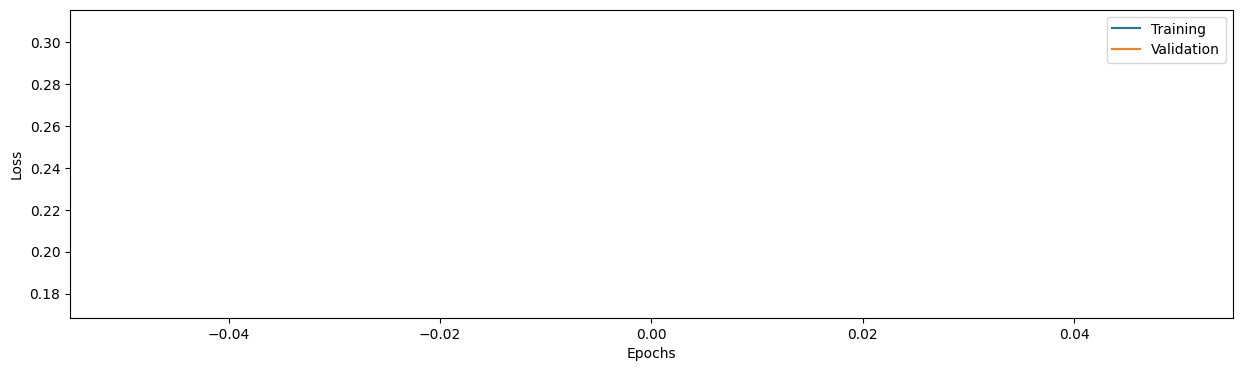

In [ ]:
# save model, scores and plot and check size of model is under 100MB
model_name = "model_on_subset"

path_name_model = "/content/model_" + model_name+".pt"
path_name_plot = "/content/model_" + model_name + "_losscurve.png"
path_name_scores = "/content/model_" + model_name + "_scores.txt"

torch.save(model.state_dict(), path_name_model)
print(f"Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Model size: {size_mb} MB")

plt.figure(figsize=(15,4))
plt.plot(train_losses,label="Training")
plt.plot(test_losses,label="Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

import json
with open(path_name_scores, 'w') as file:
     file.write(json.dumps(compute_metrics(all_preds,all_targets)))

Train model on entire training set and compute predictions

Full Model initialized.


  0%|          | 0/30 [00:00<?, ?it/s]


Train Epoch: 0 [0/45918 (0%)]	Loss: 0.708991

Train Epoch: 0 [9600/45918 (21%)]	Loss: 0.214855

Train Epoch: 0 [19200/45918 (42%)]	Loss: 0.190438

Train Epoch: 0 [28800/45918 (63%)]	Loss: 0.224455

Train Epoch: 0 [38400/45918 (84%)]	Loss: 0.201220


  3%|▎         | 1/30 [02:31<1:13:19, 151.71s/it]


Train Epoch: 1 [0/45918 (0%)]	Loss: 0.181790

Train Epoch: 1 [9600/45918 (21%)]	Loss: 0.178707

Train Epoch: 1 [19200/45918 (42%)]	Loss: 0.209091

Train Epoch: 1 [28800/45918 (63%)]	Loss: 0.194954

Train Epoch: 1 [38400/45918 (84%)]	Loss: 0.196845


  7%|▋         | 2/30 [05:02<1:10:37, 151.35s/it]


Train Epoch: 2 [0/45918 (0%)]	Loss: 0.161983

Train Epoch: 2 [9600/45918 (21%)]	Loss: 0.200465

Train Epoch: 2 [19200/45918 (42%)]	Loss: 0.191168

Train Epoch: 2 [28800/45918 (63%)]	Loss: 0.176540

Train Epoch: 2 [38400/45918 (84%)]	Loss: 0.219471


 10%|█         | 3/30 [07:37<1:08:41, 152.66s/it]


Train Epoch: 3 [0/45918 (0%)]	Loss: 0.210628

Train Epoch: 3 [9600/45918 (21%)]	Loss: 0.169119

Train Epoch: 3 [19200/45918 (42%)]	Loss: 0.178702

Train Epoch: 3 [28800/45918 (63%)]	Loss: 0.169704

Train Epoch: 3 [38400/45918 (84%)]	Loss: 0.189539


 13%|█▎        | 4/30 [10:10<1:06:13, 152.83s/it]


Train Epoch: 4 [0/45918 (0%)]	Loss: 0.159875

Train Epoch: 4 [9600/45918 (21%)]	Loss: 0.178374

Train Epoch: 4 [19200/45918 (42%)]	Loss: 0.167289

Train Epoch: 4 [28800/45918 (63%)]	Loss: 0.160784

Train Epoch: 4 [38400/45918 (84%)]	Loss: 0.150877


 17%|█▋        | 5/30 [12:42<1:03:37, 152.70s/it]


Train Epoch: 5 [0/45918 (0%)]	Loss: 0.150565

Train Epoch: 5 [9600/45918 (21%)]	Loss: 0.161239

Train Epoch: 5 [19200/45918 (42%)]	Loss: 0.195964

Train Epoch: 5 [28800/45918 (63%)]	Loss: 0.196169

Train Epoch: 5 [38400/45918 (84%)]	Loss: 0.161874


 20%|██        | 6/30 [15:15<1:01:03, 152.63s/it]


Train Epoch: 6 [0/45918 (0%)]	Loss: 0.162299

Train Epoch: 6 [9600/45918 (21%)]	Loss: 0.160852

Train Epoch: 6 [19200/45918 (42%)]	Loss: 0.149805

Train Epoch: 6 [28800/45918 (63%)]	Loss: 0.148209

Train Epoch: 6 [38400/45918 (84%)]	Loss: 0.182236


 23%|██▎       | 7/30 [17:46<58:24, 152.39s/it]  


Train Epoch: 7 [0/45918 (0%)]	Loss: 0.151759

Train Epoch: 7 [9600/45918 (21%)]	Loss: 0.188700

Train Epoch: 7 [19200/45918 (42%)]	Loss: 0.149744

Train Epoch: 7 [28800/45918 (63%)]	Loss: 0.181694

Train Epoch: 7 [38400/45918 (84%)]	Loss: 0.169504


 27%|██▋       | 8/30 [20:17<55:40, 151.84s/it]


Train Epoch: 8 [0/45918 (0%)]	Loss: 0.176728

Train Epoch: 8 [9600/45918 (21%)]	Loss: 0.157262

Train Epoch: 8 [19200/45918 (42%)]	Loss: 0.141769

Train Epoch: 8 [28800/45918 (63%)]	Loss: 0.146935

Train Epoch: 8 [38400/45918 (84%)]	Loss: 0.152560


 30%|███       | 9/30 [22:49<53:07, 151.78s/it]


Train Epoch: 9 [0/45918 (0%)]	Loss: 0.150583

Train Epoch: 9 [9600/45918 (21%)]	Loss: 0.166319

Train Epoch: 9 [19200/45918 (42%)]	Loss: 0.155137

Train Epoch: 9 [28800/45918 (63%)]	Loss: 0.162531

Train Epoch: 9 [38400/45918 (84%)]	Loss: 0.170758


 33%|███▎      | 10/30 [25:21<50:36, 151.83s/it]


Train Epoch: 10 [0/45918 (0%)]	Loss: 0.150124

Train Epoch: 10 [9600/45918 (21%)]	Loss: 0.155692

Train Epoch: 10 [19200/45918 (42%)]	Loss: 0.161367

Train Epoch: 10 [28800/45918 (63%)]	Loss: 0.163371

Train Epoch: 10 [38400/45918 (84%)]	Loss: 0.158316


 37%|███▋      | 11/30 [27:52<48:03, 151.79s/it]


Train Epoch: 11 [0/45918 (0%)]	Loss: 0.141252

Train Epoch: 11 [9600/45918 (21%)]	Loss: 0.127657

Train Epoch: 11 [19200/45918 (42%)]	Loss: 0.146322

Train Epoch: 11 [28800/45918 (63%)]	Loss: 0.163689

Train Epoch: 11 [38400/45918 (84%)]	Loss: 0.158449


 40%|████      | 12/30 [30:23<45:27, 151.52s/it]


Train Epoch: 12 [0/45918 (0%)]	Loss: 0.128239

Train Epoch: 12 [9600/45918 (21%)]	Loss: 0.121899

Train Epoch: 12 [19200/45918 (42%)]	Loss: 0.130102

Train Epoch: 12 [28800/45918 (63%)]	Loss: 0.153328

Train Epoch: 12 [38400/45918 (84%)]	Loss: 0.146146


 43%|████▎     | 13/30 [32:55<42:55, 151.51s/it]


Train Epoch: 13 [0/45918 (0%)]	Loss: 0.143007

Train Epoch: 13 [9600/45918 (21%)]	Loss: 0.153982

Train Epoch: 13 [19200/45918 (42%)]	Loss: 0.124876

Train Epoch: 13 [28800/45918 (63%)]	Loss: 0.164596

Train Epoch: 13 [38400/45918 (84%)]	Loss: 0.129417


 47%|████▋     | 14/30 [35:25<40:18, 151.14s/it]


Train Epoch: 14 [0/45918 (0%)]	Loss: 0.110021

Train Epoch: 14 [9600/45918 (21%)]	Loss: 0.153925

Train Epoch: 14 [19200/45918 (42%)]	Loss: 0.126410

Train Epoch: 14 [28800/45918 (63%)]	Loss: 0.136777

Train Epoch: 14 [38400/45918 (84%)]	Loss: 0.119341


 50%|█████     | 15/30 [37:56<37:46, 151.11s/it]


Train Epoch: 15 [0/45918 (0%)]	Loss: 0.156539

Train Epoch: 15 [9600/45918 (21%)]	Loss: 0.127656

Train Epoch: 15 [19200/45918 (42%)]	Loss: 0.103652

Train Epoch: 15 [28800/45918 (63%)]	Loss: 0.137123

Train Epoch: 15 [38400/45918 (84%)]	Loss: 0.146926


 53%|█████▎    | 16/30 [40:27<35:16, 151.16s/it]


Train Epoch: 16 [0/45918 (0%)]	Loss: 0.136519

Train Epoch: 16 [9600/45918 (21%)]	Loss: 0.134495

Train Epoch: 16 [19200/45918 (42%)]	Loss: 0.133358

Train Epoch: 16 [28800/45918 (63%)]	Loss: 0.119819

Train Epoch: 16 [38400/45918 (84%)]	Loss: 0.120679


 57%|█████▋    | 17/30 [43:02<32:57, 152.08s/it]


Train Epoch: 17 [0/45918 (0%)]	Loss: 0.124921

Train Epoch: 17 [9600/45918 (21%)]	Loss: 0.150493

Train Epoch: 17 [19200/45918 (42%)]	Loss: 0.138022

Train Epoch: 17 [28800/45918 (63%)]	Loss: 0.127423

Train Epoch: 17 [38400/45918 (84%)]	Loss: 0.119457


 60%|██████    | 18/30 [45:34<30:26, 152.23s/it]


Train Epoch: 18 [0/45918 (0%)]	Loss: 0.095370

Train Epoch: 18 [9600/45918 (21%)]	Loss: 0.137403

Train Epoch: 18 [19200/45918 (42%)]	Loss: 0.129895

Train Epoch: 18 [28800/45918 (63%)]	Loss: 0.139426

Train Epoch: 18 [38400/45918 (84%)]	Loss: 0.128088


 63%|██████▎   | 19/30 [48:05<27:49, 151.76s/it]


Train Epoch: 19 [0/45918 (0%)]	Loss: 0.113402

Train Epoch: 19 [9600/45918 (21%)]	Loss: 0.123455

Train Epoch: 19 [19200/45918 (42%)]	Loss: 0.116518

Train Epoch: 19 [28800/45918 (63%)]	Loss: 0.104969

Train Epoch: 19 [38400/45918 (84%)]	Loss: 0.165484


 67%|██████▋   | 20/30 [50:35<25:13, 151.39s/it]


Train Epoch: 20 [0/45918 (0%)]	Loss: 0.120246

Train Epoch: 20 [9600/45918 (21%)]	Loss: 0.119929

Train Epoch: 20 [19200/45918 (42%)]	Loss: 0.103978

Train Epoch: 20 [28800/45918 (63%)]	Loss: 0.123146

Train Epoch: 20 [38400/45918 (84%)]	Loss: 0.130872


 70%|███████   | 21/30 [53:06<22:41, 151.22s/it]


Train Epoch: 21 [0/45918 (0%)]	Loss: 0.132214

Train Epoch: 21 [9600/45918 (21%)]	Loss: 0.111246

Train Epoch: 21 [19200/45918 (42%)]	Loss: 0.106624

Train Epoch: 21 [28800/45918 (63%)]	Loss: 0.111674

Train Epoch: 21 [38400/45918 (84%)]	Loss: 0.112669


 73%|███████▎  | 22/30 [55:37<20:09, 151.13s/it]


Train Epoch: 22 [0/45918 (0%)]	Loss: 0.125582

Train Epoch: 22 [9600/45918 (21%)]	Loss: 0.100749

Train Epoch: 22 [19200/45918 (42%)]	Loss: 0.094650

Train Epoch: 22 [28800/45918 (63%)]	Loss: 0.136423

Train Epoch: 22 [38400/45918 (84%)]	Loss: 0.113094


 77%|███████▋  | 23/30 [58:08<17:37, 151.12s/it]


Train Epoch: 23 [0/45918 (0%)]	Loss: 0.088058

Train Epoch: 23 [9600/45918 (21%)]	Loss: 0.116168

Train Epoch: 23 [19200/45918 (42%)]	Loss: 0.122746

Train Epoch: 23 [28800/45918 (63%)]	Loss: 0.110172

Train Epoch: 23 [38400/45918 (84%)]	Loss: 0.115326


 80%|████████  | 24/30 [1:00:40<15:07, 151.21s/it]


Train Epoch: 24 [0/45918 (0%)]	Loss: 0.106588

Train Epoch: 24 [9600/45918 (21%)]	Loss: 0.117282

Train Epoch: 24 [19200/45918 (42%)]	Loss: 0.080964

Train Epoch: 24 [28800/45918 (63%)]	Loss: 0.130731

Train Epoch: 24 [38400/45918 (84%)]	Loss: 0.100571


 83%|████████▎ | 25/30 [1:03:11<12:36, 151.27s/it]


Train Epoch: 25 [0/45918 (0%)]	Loss: 0.092924

Train Epoch: 25 [9600/45918 (21%)]	Loss: 0.114347

Train Epoch: 25 [19200/45918 (42%)]	Loss: 0.114835

Train Epoch: 25 [28800/45918 (63%)]	Loss: 0.092088

Train Epoch: 25 [38400/45918 (84%)]	Loss: 0.122514


 87%|████████▋ | 26/30 [1:05:42<10:05, 151.28s/it]


Train Epoch: 26 [0/45918 (0%)]	Loss: 0.088210

Train Epoch: 26 [9600/45918 (21%)]	Loss: 0.089100

Train Epoch: 26 [19200/45918 (42%)]	Loss: 0.125453

Train Epoch: 26 [28800/45918 (63%)]	Loss: 0.094346

Train Epoch: 26 [38400/45918 (84%)]	Loss: 0.124782


 90%|█████████ | 27/30 [1:08:13<07:33, 151.12s/it]


Train Epoch: 27 [0/45918 (0%)]	Loss: 0.066915

Train Epoch: 27 [9600/45918 (21%)]	Loss: 0.124123

Train Epoch: 27 [19200/45918 (42%)]	Loss: 0.105755

Train Epoch: 27 [28800/45918 (63%)]	Loss: 0.094880

Train Epoch: 27 [38400/45918 (84%)]	Loss: 0.104232


 93%|█████████▎| 28/30 [1:10:44<05:02, 151.18s/it]


Train Epoch: 28 [0/45918 (0%)]	Loss: 0.106143

Train Epoch: 28 [9600/45918 (21%)]	Loss: 0.077309

Train Epoch: 28 [19200/45918 (42%)]	Loss: 0.142036

Train Epoch: 28 [28800/45918 (63%)]	Loss: 0.111949

Train Epoch: 28 [38400/45918 (84%)]	Loss: 0.092049


 97%|█████████▋| 29/30 [1:13:17<02:31, 151.54s/it]


Train Epoch: 29 [0/45918 (0%)]	Loss: 0.094456

Train Epoch: 29 [9600/45918 (21%)]	Loss: 0.081981

Train Epoch: 29 [19200/45918 (42%)]	Loss: 0.098969

Train Epoch: 29 [28800/45918 (63%)]	Loss: 0.097416

Train Epoch: 29 [38400/45918 (84%)]	Loss: 0.075487


100%|██████████| 10000/10000 [00:47<00:00, 211.81it/s]



Predictions computed for test set.


100%|██████████| 10000/10000 [00:46<00:00, 214.14it/s]



Predictions computed for test set.


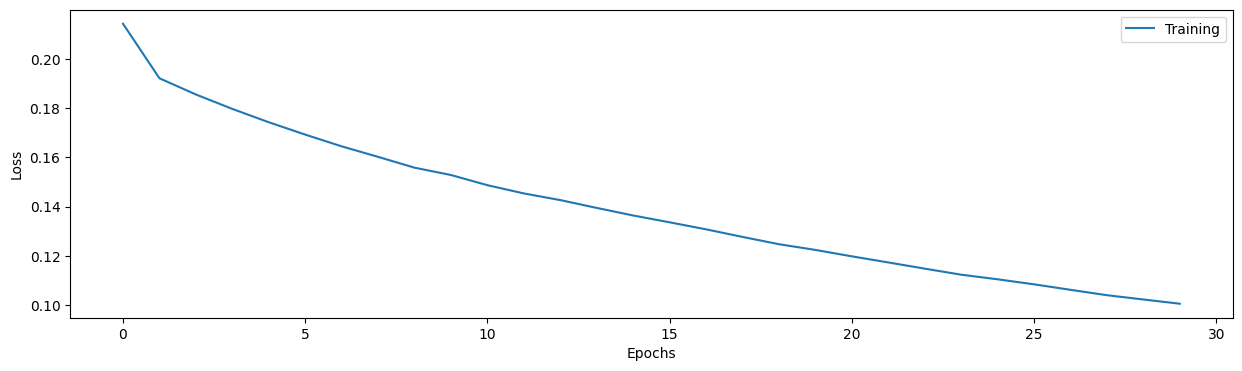

In [53]:
# Training new model on the full dataset
model_full = CNN().to(device)
c_weights_full = c_weights.to(device)
loss_full = torch.nn.BCEWithLogitsLoss()
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=lr)
print('Full Model initialized.')
log_interval = 150 # How often we print train loss
train_losses_full = train_network(log_interval,model_full, device, train_dataloader, test_loader=0,optimizer=optimizer_full, loss=loss_full,epochs=30)

plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')

# Compute predictions for true test set
thresholds_full = [0.5]*18
test_pred_full = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=True)
test_pred_full_predict_all_false = test(model_full, device, test_dataloader,loss_full,thresholds=thresholds_full,target_available=False,predict_all=False)

Save full model, check size and get predictions

Full Model saved to /content/model_final_full.pt
Full Model size: 6.492229461669922 MB
Submission dataframe:
<bound method NDFrame.describe of         ImageID   Labels
0     30000.jpg       17
1     30001.jpg        1
2     30002.jpg        1
3     30003.jpg        1
4     30004.jpg        1
...         ...      ...
9995  39995.jpg        1
9996  39996.jpg  1 3 4 8
9997  39997.jpg        1
9998  39998.jpg        1
9999  39999.jpg        1

[10000 rows x 2 columns]>
Predictions saved as /content/submission.csv


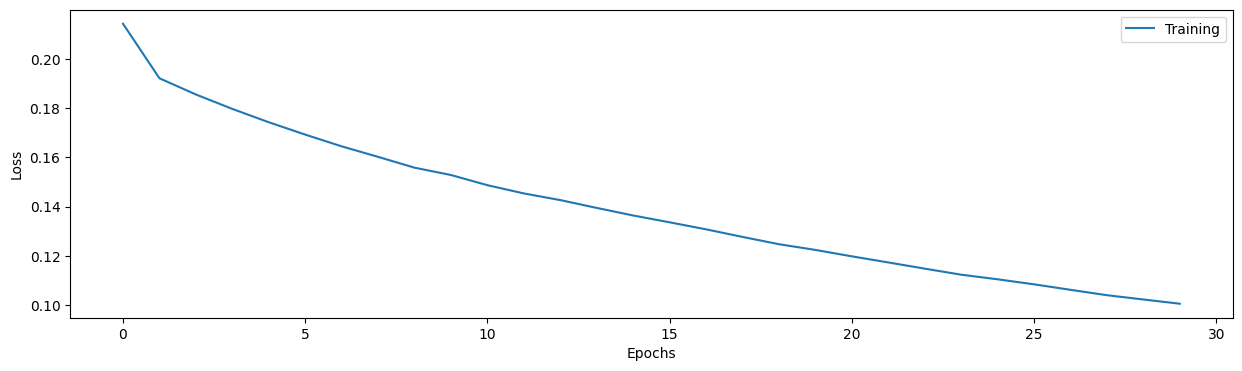

In [56]:
# Convert predictions to csv
from tqdm import tqdm
import numpy as np

# Simple function to get label from encoded vector
def get_class(array):
  class_pred = np.where(array > 0.5)[1] + 1
  for i in range(len(class_pred)):
    if class_pred[i] >= 12:
      class_pred += 1
  return class_pred

# Simple function to get predictions as strings
def unencode(y_pred,to_cpu=True):
  labels = []
  for i in range(len(y_pred)):
    if to_cpu: # Move to cpu device
      temp = y_pred[i].cpu()
    temp = np.asarray(temp)
    temp = get_class(temp)
    temp = " ".join(str(item) for item in temp)
    labels.append(temp)
  return labels

# Save full model
model_name = "final"
path_name_model = "/content/model_" + model_name + "_full.pt"
path_name_plot = "/content/model_" + model_name + "_losscurve_full.png"
torch.save(model_full.state_dict(), path_name_model)
print(f"Full Model saved to {path_name_model}")
size_mb = os.path.getsize(path_name_model) / (1024 * 1024)
print(f"Full Model size: {size_mb} MB")

# Save loss plot
plt.figure(figsize=(15,4))
plt.plot(train_losses_full,label="Training")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.savefig(path_name_plot)

#Save predictions in csv
pred_labels = unencode(test_pred_full_predict_all_false)
pred_df = df_test.copy()
pred_df = pred_df.drop("Caption",axis=1)
pred_df["Labels"] = pred_labels
print("Submission dataframe:")
print(pred_df.describe)
submission_name = "/content/submission.csv"
pred_df.to_csv(submission_name,index=False)
print(f"Predictions saved as {submission_name}")

In [57]:
# Submit predictions to kaggle
! kaggle competitions submit -c multi-label-classification-competition-2025 -f /content/submission.csv -m "25-05-2025 v1 (predict all false) "

100% 124k/124k [00:01<00:00, 123kB/s]
Successfully submitted to Multi-label Classification Competition 2025